# 
<a id="data-prep"></a>
<div style="background-color: #000D5B; color: white; text-align: center; padding: 6px 0 22px 0">
    <h3 style="background-color: #000D5B; color: white; text-align: left">RMIT School of Computer Science and Technology</h3>
    <br/>
    <h1>COSC3007: Deep Learning</h1>
    <h2>Assignment 2: Stance Twitter Sentiment Analysis and Detection </h2>
    <h2> [1] DATA PREPROCESSING AND EDA </h2>

</div>

## Navigation

* [I. Import data, usefull libraries and packages](#import-package)
* [II. Data overview](#ii)
* [III. Exploratory Data Aalysis (EDA)](#iii)
* [IV. Data Preprocessing](#vi)
* [V. Modelling](#v)
* [Nav3](#3)
    * [Sub-nav3](#3.1)
    

<a id='import-package'></a>
### I. Import data, usefull libraries and packages

In [95]:
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

import re
import string
import nltk
import os
import spacy
import matplotlib.pyplot as plt

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from itertools import chain
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

from pathlib import Path
from collections import Counter


[nltk_data] Downloading package punkt to /Users/vuvoquoc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vuvoquoc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/vuvoquoc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vuvoquoc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [96]:
train_origin_df = pd.read_csv("./StanceDataset/train.csv", encoding = "ISO-8859-1", engine="python")
test_origin_df = pd.read_csv("./StanceDataset/test.csv", encoding = "ISO-8859-1", engine="python")
trump_train_df = pd.read_csv("./StanceDataset/raw_train_trump.csv", encoding = "ISO-8859-1", engine="python")
trump_train_df.rename(columns={'text': 'Tweet', 'label':'Stance'}, inplace = True)
trump_train_df['Target'] = "Donald Trump"
trump_train_df = trump_train_df.drop(columns=['tweet_id'])

# Remove rows with NaN values in the 'tweet' column
trump_train_df = trump_train_df.dropna(subset=['Tweet'])

# train_origin_df = pd.concat([train_origin_df, splitted_trump_df])
train_origin_df = pd.concat([train_origin_df, trump_train_df])

In [97]:
cleaned_nan_count = trump_train_df['Tweet'].isna().sum()
cleaned_nan_count

0

<a id='ii'></a>
### II. Data overview

In [98]:
# Display 5 rows of train df
train_origin_df.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [99]:
# Display 5 rows of train df
test_origin_df.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [100]:
# Display data length
print('Data length:', len(train_origin_df))
print('Data length:', len(test_origin_df))

Data length: 3789
Data length: 1956


In [101]:
# Display data infomation 
print('Data infomation: ', train_origin_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3789 entries, 0 to 874
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweet            3789 non-null   object
 1   Target           3789 non-null   object
 2   Stance           3789 non-null   object
 3   Opinion Towards  2914 non-null   object
 4   Sentiment        2914 non-null   object
dtypes: object(5)
memory usage: 177.6+ KB
Data infomation:  None


In [102]:
# Dispay missing value and percentage of missing value
missing_data = train_origin_df.isna().sum().sort_values(ascending=False)
percentage_missing = round((train_origin_df.isnull().sum()/train_origin_df.isnull().count()).sort_values(ascending=False)*100,2)
train_missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
train_missing_info

,Missing values,Percentage
Opinion Towards,875,23.09
Sentiment,875,23.09
Tweet,0,0.00
Target,0,0.00
Stance,0,0.00


In [103]:
# Dispay missing value and percentage of missing value
missing_data = train_origin_df.isna().sum().sort_values(ascending=False)
percentage_missing = round((test_origin_df.isnull().sum()/test_origin_df.isnull().count()).sort_values(ascending=False)*100,2)
test_missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
test_missing_info

,Missing values,Percentage
Opinion Towards,875,0.0
Sentiment,875,0.0
Tweet,0,0.0
Target,0,0.0
Stance,0,0.0


 #### Observation: 
- The train data contain 4 columns, 2914 rows 
- The test data contain 4 columns, 1956 rows
- Both of train and test does not have missing values
- Data type of train and test are qobject 
- Domain knowledge: 
    - Tweet: Tweet status on tweeter
    - Target: The target that the tweet is aiming at
    - Stance: Catagorical of against, favor or none for the target
    - Sentiment: Categorical of negative, positive or other of the tweet

<a id='iii'></a>
### III. Exploratory Data Analysis

#### Number of unique Sentiment

Unique Sentiment:  ['neg' 'pos' 'other' nan]


/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_64564/3848142554.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Sentiment', data=train_origin_df, palette='Set2')  # Using 'Set2' palette


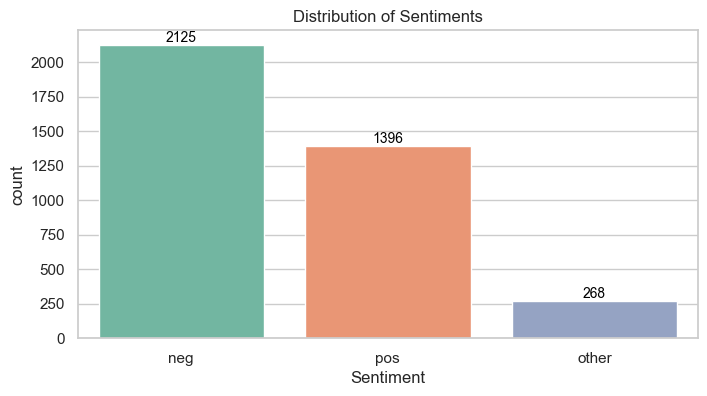

In [104]:
print('Unique Sentiment: ', train_origin_df['Sentiment'].unique())

# Setting the aesthetics for seaborn
sns.set(style="whitegrid")

# Plotting bar chart for 'Sentiment' with count annotations and a color palette
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Sentiment', data=train_origin_df, palette='Set2')  # Using 'Set2' palette
plt.title('Distribution of Sentiments')

# Adding count annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

 #### Observation: 
- Uneven distribution of sentiment accross the trainset, which therefore, usage of sentiment to train the model weight, might lead to biases

#### Number of unique Stance

Unique Stance:  ['AGAINST' 'FAVOR' 'NONE']


/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_64564/3975082987.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Stance', data=train_origin_df, palette='viridis')  # Using 'viridis' palette


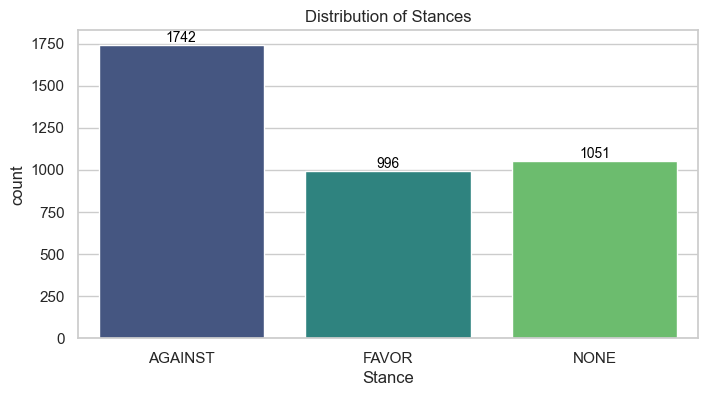

In [105]:
print('Unique Stance: ', train_origin_df['Stance'].unique())

# Setting the aesthetics for seaborn
sns.set(style="whitegrid")

# Plotting bar chart for 'Stance' with count annotations and a color palette
plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Stance', data=train_origin_df, palette='viridis')  # Using 'viridis' palette
plt.title('Distribution of Stances')

# Adding count annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

 #### Observation: 
- Data imbalanced toward Against label.

#### Number of unique Train Target

Unique Target:  ['Hillary Clinton' 'Legalization of Abortion' 'Atheism'
 'Climate Change is a Real Concern' 'Feminist Movement' 'Donald Trump']


/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_64564/2752228154.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='Target', data=train_origin_df, palette='coolwarm')  # Using 'coolwarm' palette


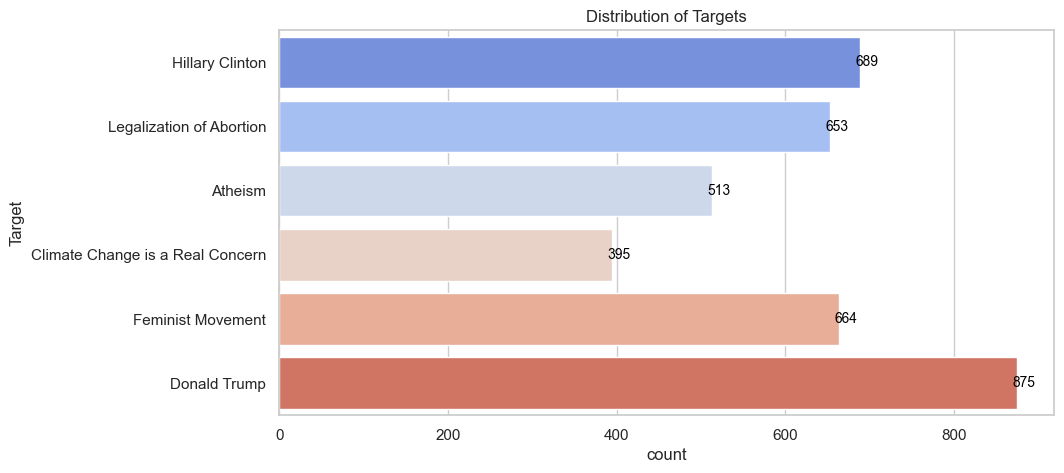

In [106]:
print('Unique Target: ', train_origin_df['Target'].unique())

# Setting the aesthetics for seaborn
sns.set(style="whitegrid")

# Plotting bar chart for 'Target' with count annotations
plt.figure(figsize=(10, 5))
ax = sns.countplot(y='Target', data=train_origin_df, palette='coolwarm')  # Using 'coolwarm' palette
plt.title('Distribution of Targets')

# Adding count annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=10, color='black', xytext=(5, 0),
                textcoords='offset points')

plt.show()

 #### Obseration: 
- Target distribution is stable for pre-train model, since most of the class are even

#### Number of unique Test Target

Unique Target:  ['Atheism' 'Climate Change is a Real Concern' 'Feminist Movement'
 'Hillary Clinton' 'Legalization of Abortion' 'Donald Trump']


/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_64564/1154771592.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='Target', data=test_origin_df, palette='tab10')  # Using 'tab10' palette


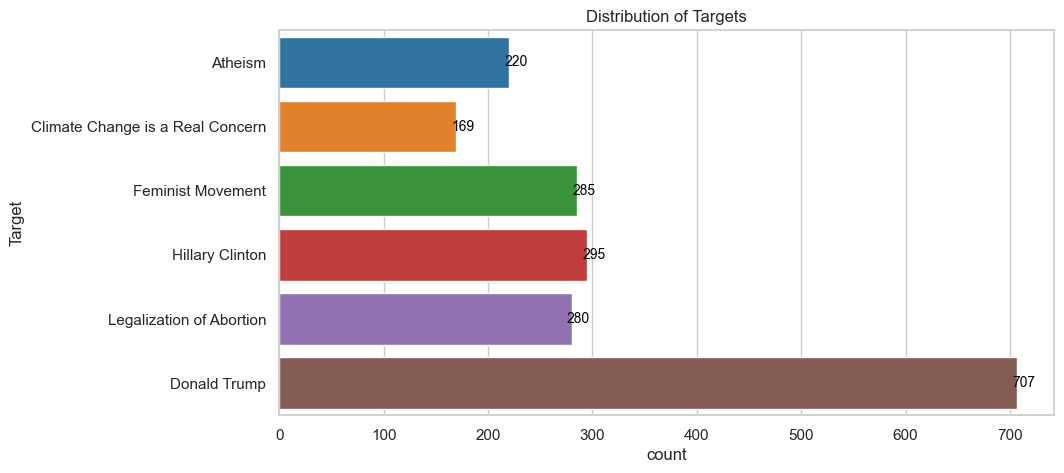

In [107]:
# Assuming test_origin_df is your DataFrame and 'Target' is a column in it
print('Unique Target: ', test_origin_df['Target'].unique())

# Setting the aesthetics for seaborn
sns.set(style="whitegrid")

# Plotting bar chart for 'Target' with count annotations
plt.figure(figsize=(10, 5))
ax = sns.countplot(y='Target', data=test_origin_df, palette='tab10')  # Using 'tab10' palette
plt.title('Distribution of Targets')

# Adding count annotations
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=10, color='black', xytext=(5, 0),
                textcoords='offset points')

plt.show()

 #### Obseration: 
- Test set has DonaldTrump which would reduce the performance of the finalized model, sice the trainset does not contain DonaldTrump related tweets

#### Unique Sentiment count on each Target 

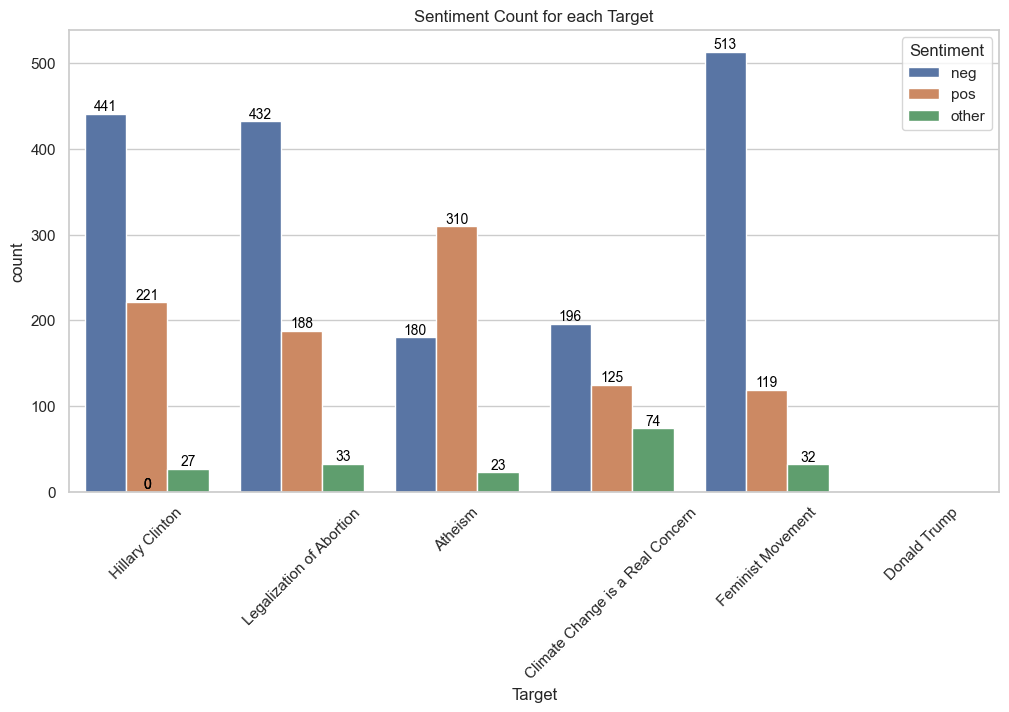

In [108]:
# Setting the aesthetics for seaborn
sns.set(style="whitegrid")

# Plotting bar chart for Sentiment count for each Target
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Target', hue='Sentiment', data=train_origin_df)
plt.title('Sentiment Count for each Target')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

 #### Obseration: 
- The bar chart shows "Feminist Movement" and "Hillary Clinton" as the most discussed targets, with "Climate Change is a Real Concern" being the least. "Hillary Clinton" predominantly elicits negative sentiment, while "Climate Change" garners positive sentiment. The "Feminist Movement" has a notable proportion of 'other' sentiments, indicating nuanced views. There is an evident sentiment imbalance across targets, which could bias a predictive model. The dataset likely reflects particular temporal trends or events influencing these discussions.

#### Unique Stance count on each Target 

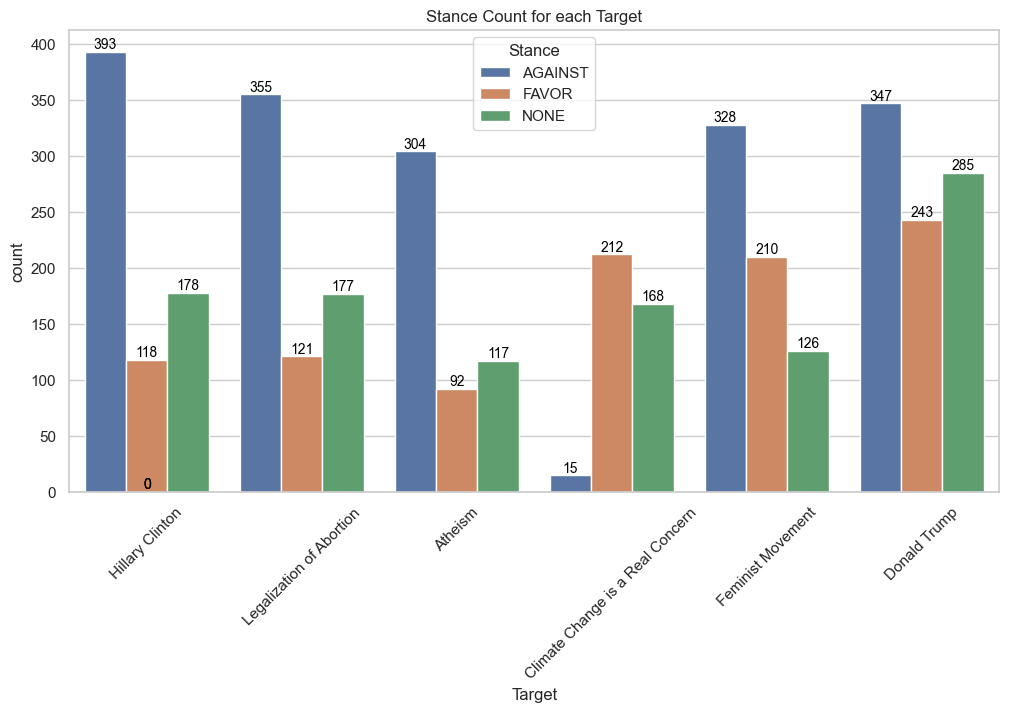

In [109]:
# Plotting bar chart for Stance count for each Target
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Target', hue='Stance', data=train_origin_df)
plt.title('Stance Count for each Target')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

 #### Obseration: 
- "Hillary Clinton" as the target with the most stances against, while "Climate Change is a Real Concern" and "Feminist Movement" have the highest number of favorable stances. "Atheism" has a balanced stance distribution but the fewest neutral positions. Overall, "none" stances are least common, suggesting strong opinions on most targets. The distribution suggests a dataset likely influenced by specific societal or political events.

#### Most common words

In [110]:
# Function to clean and split text
def clean_and_split(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and non-ascii
    text = re.sub(r'[^\w\s]', '', text)
    # Split into words
    words = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    meaningful_words = [w for w in words if w not in stop_words]
    return meaningful_words

Most Common Words: [('semst', 2814), ('user', 1490), ('trump', 260), ('http', 240), ('people', 197), ('dont', 196), ('god', 194), ('like', 189), ('hillaryclinton', 170), ('women', 167)]


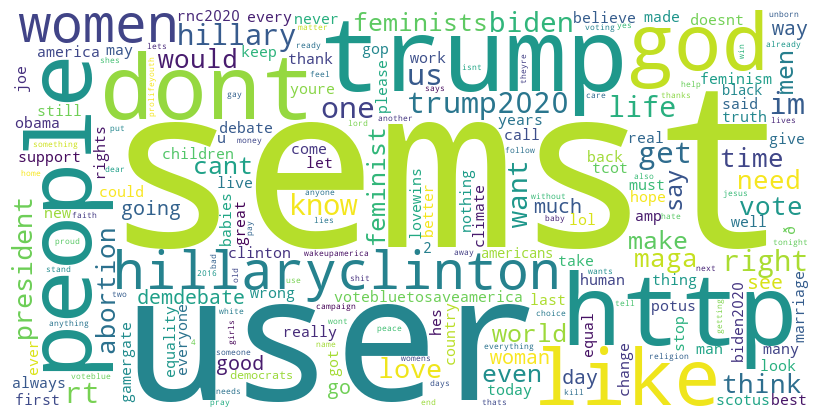

In [111]:
# Apply the function to the Tweet column and concatenate all words
all_words = train_origin_df['Tweet'].apply(clean_and_split).sum()

# Count most common words
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(10)
print("Most Common Words:", most_common_words)

# Generate a word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(word_counts)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show()

 #### Obseration: 
- Highlights prominent terms from a collection of text, likely related to social or political discourse. Words like "abortion," "Clinton," "feminist," and "equality" are prominent, suggesting these topics are frequently mentioned. The sizeable representation of "God," "love," and "people" implies a focus on personal values and human-centric discussion. The interplay of words such as "woman," "men," "feminists," alongside "need," "world," and "change," indicates debates around gender issues and societal change. The presence of both "Hillary" and "Clinton" in large fonts suggests a significant focus on political figures, with "Hillary Clinton" likely being a central figure in the discourse

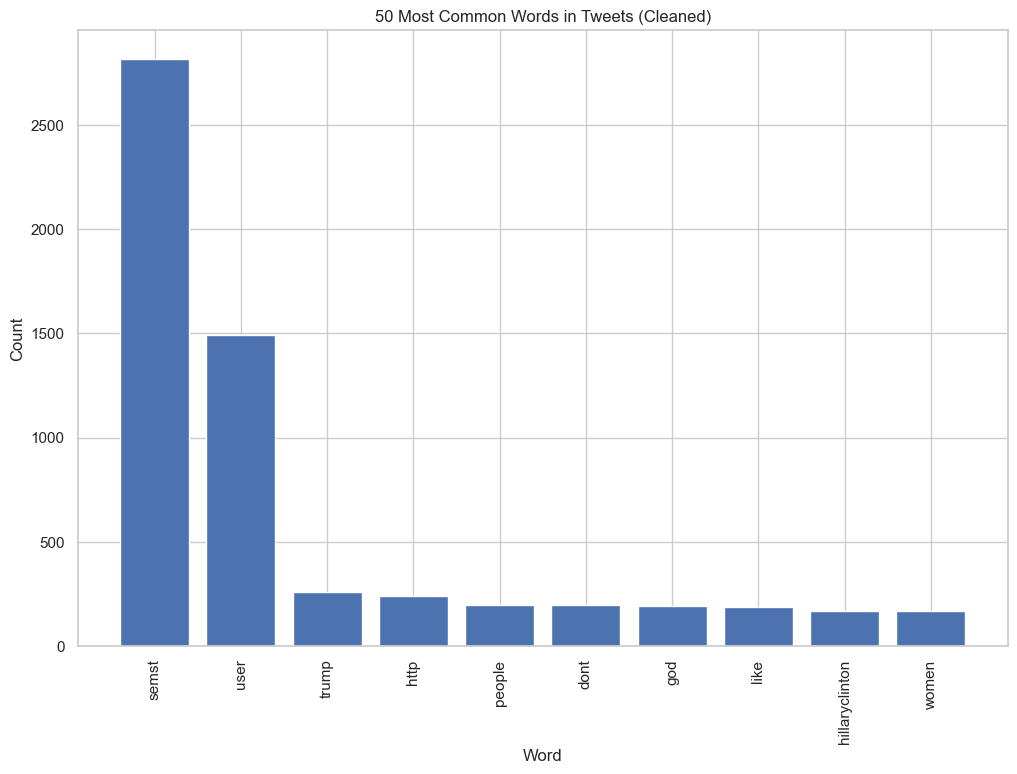

In [112]:
# Apply the function to the Tweet column and concatenate all words
all_words = train_origin_df['Tweet'].apply(clean_and_split).sum()

# Count most common words
word_counts = Counter(all_words)
most10Freq = word_counts.most_common(10)

# Convert to DataFrame for easier plotting
top50df = pd.DataFrame(most10Freq, columns=['word', 'count'])

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top50df['word'], top50df['count'])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("50 Most Common Words in Tweets (Cleaned)")
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.show()

 #### Obseration: 
- #SEMST is the most mentioned item with 2500+ times being mentioned, consideration to be removed

#### Correlation between stance and others features

In [113]:
#Encode the target and stance to intgers for classification

encode_target = {
    "Hillary Clinton" : 0,
    "Legalization of Abortion"  : 1,       
    "Atheism" : 2,    
    "Climate Change is a Real Concern" : 3,     
    "Feminist Movement"  : 4,
    "Donald Trump": 5
}

encode_stance = {
    "AGAINST" : 0,
    "FAVOR"  : 1,       
    "NONE" : 2,    
}

encode_sentiment = {
    "neg" : 0,
    "pos"  : 1,       
    "other" : 2,    
}

#Apply encoding for Stance feature
train_origin_df["Target"] = train_origin_df["Target"].apply(lambda x: encode_target[x])
test_origin_df["Target"] = test_origin_df["Target"].apply(lambda x: encode_target[x])

#Apply encoding for Stance feature
train_origin_df["Stance"] = train_origin_df["Stance"].apply(lambda x: encode_stance[x])
test_origin_df["Stance"] = test_origin_df["Stance"].apply(lambda x: encode_stance[x])

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_64564/626463087.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_origin_df.corr()


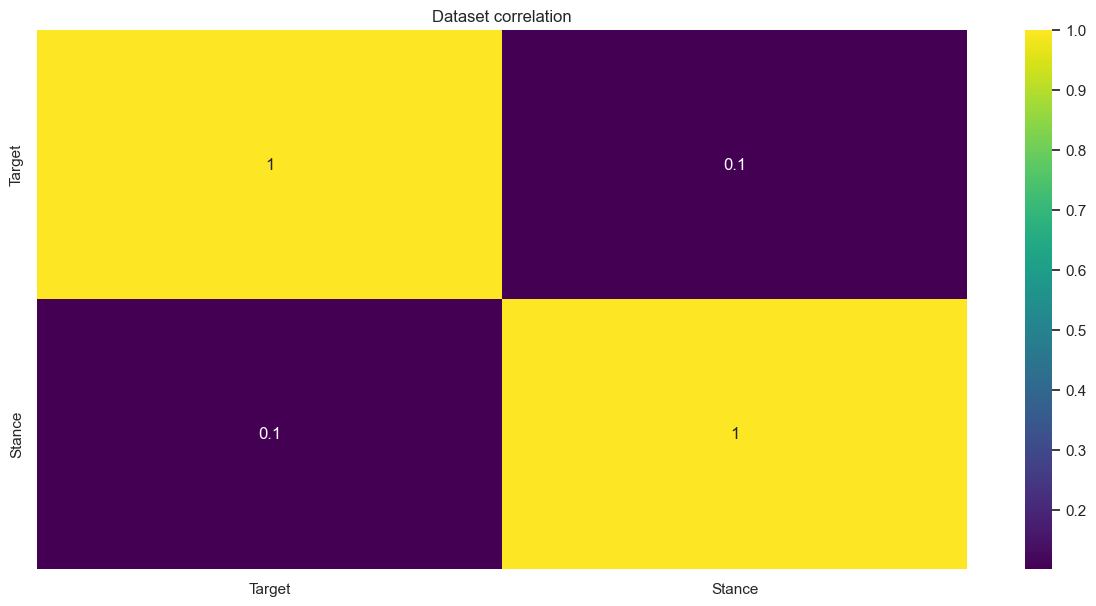

In [114]:
correlation = train_origin_df.corr()
plt.figure(figsize=(15, 7))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title("Dataset correlation")
plt.show()

 #### Obseration: 
- Weak Correlation between labels features

<a id='vi'></a>
### VI. Data preprocessing

In [115]:
# Global Variables
STOP_WORDS = set(stopwords.words('english'))
PUNCTUATION_TRANSLATOR = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
SPACY_MODEL = spacy.load('en_core_web_sm')
URL_REGEX = re.compile(r"http\S+|www\S+|https\S+|http")
NON_ASCII_REGEX = re.compile(r'[^\x00-\x7F]+')
NUMBER_REGEX = re.compile(r'[0-9]')
SHORT_WORD_REGEX = re.compile(r'\b\w{1,2}\b')
EXTRA_SPACE_REGEX = re.compile(r"\s+")
RESERVED_WORDS_REGEX = re.compile(r"\b(rt|fav)\b")
MENTION_REGEX = re.compile(r'@\w+')
HASHTAG_REGEX = re.compile(r'#\w+')



In [116]:
# Function to process tweet
def preprocess_tweets(df, column_name='Tweet'):
    def process_tweet(tweet):
      try:
        tweet = tweet.lower()
        tweet = URL_REGEX.sub('', tweet)
        tweet = MENTION_REGEX.sub('', tweet)
        # tweet = HASHTAG_REGEX.sub('', tweet)  # Remove hashtags
        tweet = NON_ASCII_REGEX.sub('', tweet)
        tweet = tweet.translate(PUNCTUATION_TRANSLATOR)
        tweet = NUMBER_REGEX.sub('', tweet)
        tweet = RESERVED_WORDS_REGEX.sub('', tweet)
        tweet = SHORT_WORD_REGEX.sub('', tweet)
        tweet = EXTRA_SPACE_REGEX.sub(' ', tweet).strip()

        # Extracting and processing tokens
        doc = SPACY_MODEL(tweet)
        tokens = [token.lemma_ if token.lemma_ != '-PRON-' else token.lower_ for token in doc]
        tokens = [token for token in tokens if token not in STOP_WORDS]

        return " ".join(tokens)

      except Exception as e:
        print(f"Error processing tweet: {e}")
      return ""
    # Apply the preprocessing to the specified column
    df['processed_tweet'] = df[column_name].apply(lambda x: process_tweet(x))
    return df

In [117]:
# Reference: This is a snipped of code implemented from COSC3015-Advance programming for Data Science
def statsPrint(tokenised_articles): # TO CHECK THE STATS OF THE TWEETS
    words = list(chain.from_iterable(tokenised_articles)) 
    vocab = set(words)
    lexical_diversity = len(vocab)/len(words)
    print("Vocabulary size: ",len(vocab))
    print("Total number of tokens: ", len(words))
    print("Lexical diversity: ", lexical_diversity)
    print("Total number of tweets:", len(tokenised_articles))
    lens = [len(article) for article in tokenised_articles]
    print("Average document length:", np.mean(lens))
    print("Maximum document length:", np.max(lens))
    print("Minimum document length:", np.min(lens))
    print("Standard deviation of document length:", np.std(lens))

In [118]:
def plot_label_count(df, label1, label2):
  sns.set(rc={'figure.figsize':(15,5)})
  sns.set_theme(style="darkgrid")
  ax = sns.countplot(x=label1,hue=label2 ,data=df)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  # Adding the text on the bars
  for p in ax.patches:
      ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
              fontsize=12, color='black', ha='center', va='bottom')

Process Tweets

In [119]:
train_df = preprocess_tweets(train_origin_df, 'Tweet')
test_df = preprocess_tweets(test_origin_df, 'Tweet')

Final Look at top words

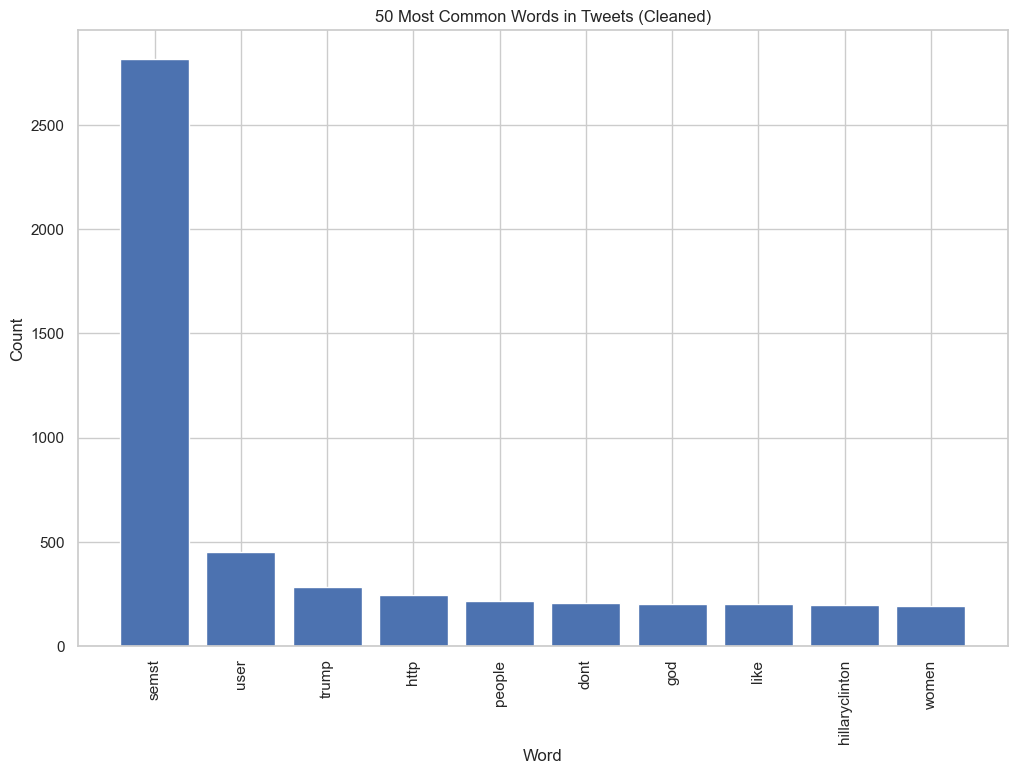

In [120]:
# Apply the function to the Tweet column and concatenate all words
all_words = train_df['processed_tweet'].apply(clean_and_split).sum()

# Count most common words
word_counts = Counter(all_words)
most10Freq = word_counts.most_common(10)

# Convert to DataFrame for easier plotting
top10df = pd.DataFrame(most10Freq, columns=['word', 'count'])

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top50df['word'], top10df['count'])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("50 Most Common Words in Tweets (Cleaned)")
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.show()

Remove No Meanings Words

In [121]:
# Remove top 5 words
# Assuming most10Freq is a list of tuples with the top 10 most common words and their counts
top1 = word_counts.most_common(1)

def remove_top_words(tweet):
    return ' '.join(word for word in tweet.split() if word not in top1)

# Now apply the function to the 'Tweet' column
train_df['processed_tweet'] = train_df['processed_tweet'].apply(remove_top_words)

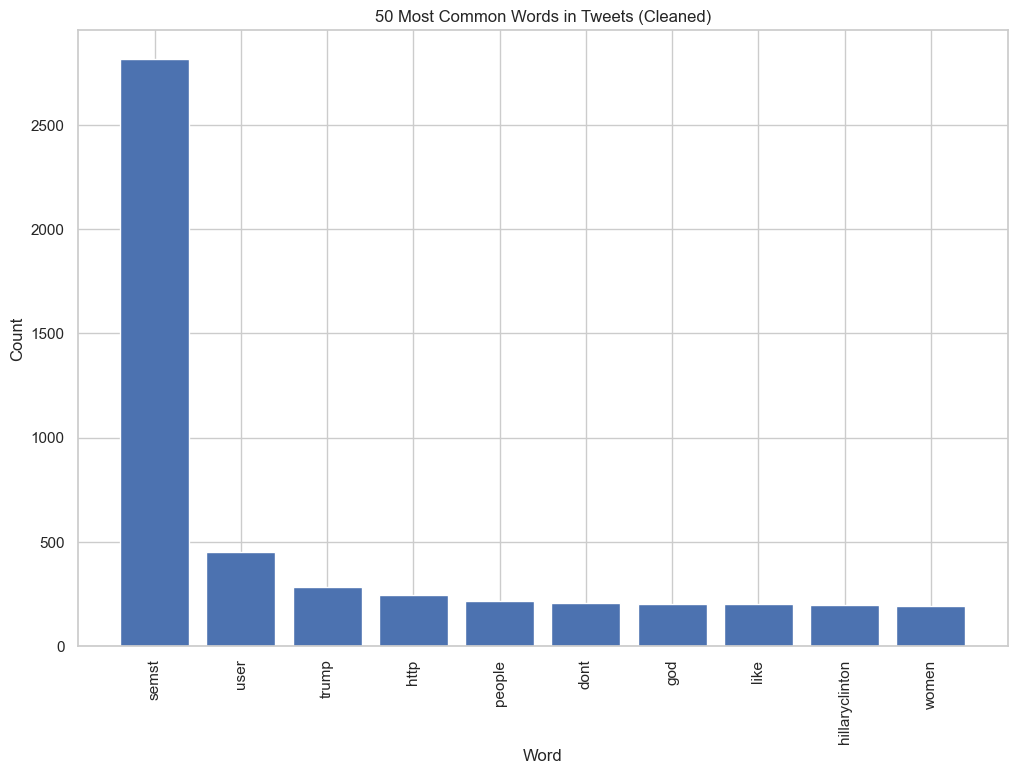

In [122]:
# Apply the function to the Tweet column and concatenate all words
all_words = train_df['processed_tweet'].apply(clean_and_split).sum()

# Count most common words
word_counts = Counter(all_words)
most10Freq = word_counts.most_common(10)

# Convert to DataFrame for easier plotting
top10df = pd.DataFrame(most10Freq, columns=['word', 'count'])

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top50df['word'], top10df['count'])
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("50 Most Common Words in Tweets (Cleaned)")
plt.xticks(rotation=90)  # Rotate the x labels for better readability
plt.show()

In [123]:
statsPrint(train_df['Tweet'])
print(" ")
statsPrint(test_df['Tweet'])    

Vocabulary size:  161
Total number of tokens:  452735
Lexical diversity:  0.00035561642020166324
Total number of tweets: 3789
Average document length: 119.48667194510425
Maximum document length: 560
Minimum document length: 4
Standard deviation of document length: 50.658458144848964
 
Vocabulary size:  90
Total number of tokens:  212042
Lexical diversity:  0.0004244442138821554
Total number of tweets: 1956
Average document length: 108.40593047034764
Maximum document length: 142
Minimum document length: 31
Standard deviation of document length: 25.235857680823553


In [124]:
statsPrint(train_df['processed_tweet'])
print(" ")
statsPrint(test_df['processed_tweet'])

Vocabulary size:  28
Total number of tokens:  268075
Lexical diversity:  0.00010444838198265411
Total number of tweets: 3789
Average document length: 70.75085774610716
Maximum document length: 243
Minimum document length: 0
Standard deviation of document length: 32.57820365390751
 
Vocabulary size:  28
Total number of tokens:  125428
Lexical diversity:  0.00022323564116465223
Total number of tweets: 1956
Average document length: 64.12474437627812
Maximum document length: 117
Minimum document length: 9
Standard deviation of document length: 20.522937967256713


Save Processed Tweets

In [125]:
train_file_path = './StanceDataset/processed_train_balanced.csv'
test_file_path = './StanceDataset/processed_test_balanced.csv'

train_df.to_csv(train_file_path)
test_df.to_csv(test_file_path)